# Trabajo Practico Final

---

## Integrantes:

- Herrera, Daniel Fernando
- Pacheco Barrios, Niels Víctor 
- Perez Omodeo, Carolina


El presente notebook es el MVP, que luego se migró a una estructura de Pre-Producción.

---
---

# Desarrollo

In [94]:
#pip install transformers datasets diffusers accelerate

In [95]:
#pip install python-dotenv

In [96]:
#pip install -r ../requirements_torch.txt --index-url https://download.pytorch.org/whl/cu124

In [97]:
from huggingface_hub import login
from dotenv import load_dotenv
import os
from datasets import load_dataset, Dataset, concatenate_datasets
from copy import deepcopy
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import gc

In [98]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device) # Expected: ‘cuda’ if Linux else ‘mps’ if MacOS
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


In [99]:
load_dotenv()
token = os.getenv("HUGGINGFACE_HUB_TOKEN")

login(token=token)

## Datos: gymprathap/Breast-Cancer-Ultrasound-Images-Dataset

In [100]:
# [migracion] migrado.
dataset_dir = load_dataset("gymprathap/Breast-Cancer-Ultrasound-Images-Dataset")

In [101]:
# [migracion] migrado.
print(dataset_dir)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1578
    })
})


In [102]:
# [migracion] migrado.
split1 = dataset_dir['train'].train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
temp_train = split1["train"]
data_test = split1["test"]

split2 = temp_train.train_test_split(test_size=0.1, stratify_by_column="label", seed=42)
data_train = split2["train"]
data_valid = split2["test"]

In [ ]:
# [migracion]
data_test_original = deepcopy(data_test)

# [migracion] no se utilizan, entonces no se migran.
data_train_original = deepcopy(data_train)
data_valid_original = deepcopy(data_valid)

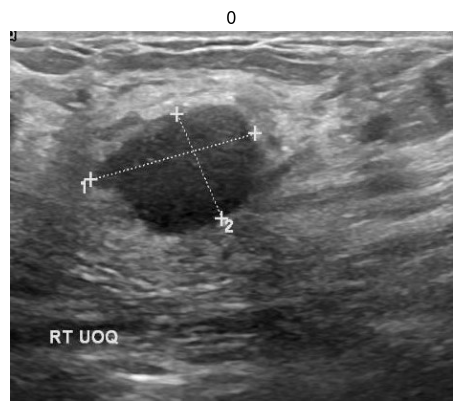

In [104]:
# [migracion] migrado. salva ejemplo en carpeta 'output'
sample = data_train[1]
plt.imshow(sample['image'])
plt.title(sample['label'])
plt.axis("off")
plt.show()

In [105]:
# [migracion] migrado.

# Verificar tamaños
print(f"Train size: {len(data_train)}")
print(f"Test size: {len(data_test)}")
print(f"Validation size: {len(data_valid)}")

Train size: 1135
Test size: 316
Validation size: 127


In [106]:
# # [migracion] migrado.
labels = data_train.features['label'].names
print(labels)

['benign', 'malignant', 'normal']


## Modelo preentrenado

In [107]:
# [migrado] main
selected_model = 'facebook/deit-base-patch16-224'
processor = AutoImageProcessor.from_pretrained(selected_model)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [108]:
num_labels = len(labels) # [migracion] migrado.

# [migrado] model.py
# Adaptamos el modelo
model = AutoModelForImageClassification.from_pretrained(
    selected_model,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
#  [migrado] proprocess.py
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.GaussianBlur(kernel_size=(3, 3)),
])


In [110]:
# [migrado]
def transform_dataset(example, transform=None):
    image = example['image']

    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    if image.mode != "RGB":
        image = image.convert("RGB")

    if transform:
        image = transform(image)

    inputs = processor(images=image, return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'].squeeze(0)
    example['label'] = example['label']

    return example

In [111]:
# [migrado]
data_train = data_train.map(lambda x: transform_dataset(x, transform), batched=False)
data_valid = data_valid.map(lambda x:transform_dataset(x), batched=False)
data_test = data_test.map(lambda x: transform_dataset(x), batched=False)

Map: 100%|██████████| 1135/1135 [02:04<00:00,  9.09 examples/s]


In [112]:
torch.cuda.empty_cache()
gc.collect()

38472

In [113]:
# [migrado] a probar
def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['label'] for item in batch]
    return {
        'pixel_values': torch.stack(pixel_values),
        'labels': torch.tensor(labels)
    }

In [114]:
# [migrado] a probar
eval_dataloader = DataLoader(data_test, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [115]:
data_test

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 316
})

In [ ]:
#c [MIGRADO]
data_train.set_format(type='torch', columns=['pixel_values','label'])
data_valid.set_format(type='torch', columns=['pixel_values','label'])
data_test.set_format(type='torch', columns=['pixel_values','label'])

### <<<<  [DH] Hasta aqui es proprocesamiento

In [117]:
# [migrado] a probar
def evaluate_model(model, dataloader, labels, dataset_raw, device='cpu'):
    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []
    
    # Para las primeras imágenes
    images_to_show = []
    predictions_to_show = []
    labels_to_show = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels_batch = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

            if i < 1:
                for j in range(min(15, len(labels_batch))):
                    images_to_show.append(dataset_raw[i * dataloader.batch_size + j]['image'])
                    predictions_to_show.append(predictions[j].item())
                    labels_to_show.append(labels_batch[j].item())

    # Convertimos a numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Detectar clases presentes en los datos
    present_class_indices = sorted(np.unique(np.concatenate([all_labels, all_predictions])))
    present_class_names = [labels[i] for i in present_class_indices]
    
    # Métricas
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='macro')
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, labels=present_class_indices, target_names=present_class_names))

    # Mostrar imágenes
    plt.figure(figsize=(20, 10))
    for i in range(len(images_to_show)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images_to_show[i])
        plt.title(f"Pred: {labels[predictions_to_show[i]]}\nTrue: {labels[labels_to_show[i]]}")
        plt.axis('off')
    plt.suptitle("Predicciones vs. Etiquetas verdaderas (primeras 15 imágenes)", fontsize=16)
    plt.tight_layout()
    plt.show()


In [118]:
torch.cuda.empty_cache()
gc.collect()

0

## Fine-tuning del modelo

In [119]:
#[migrado] trainer.py

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16, 
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True
)

In [120]:
# [migrado]
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

In [121]:
#[migrado] trainer.py

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train,
    eval_dataset=data_valid,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

C:\Users\caro_\AppData\Local\Temp\ipykernel_33376\2436116264.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [122]:
#[migrado] trainer.py
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.311300,0.304556,0.874016
2,0.194700,0.221706,0.905512
3,0.045300,0.171345,0.921260
4,0.007200,0.196256,0.921260
5,0.004200,0.182905,0.929134


TrainOutput(global_step=355, training_loss=0.15116734136368187, metrics={'train_runtime': 273.2395, 'train_samples_per_second': 20.769, 'train_steps_per_second': 1.299, 'total_flos': 4.397709825556992e+17, 'train_loss': 0.15116734136368187, 'epoch': 5.0})

In [123]:
# [migrado] a probar
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.17134538292884827, 'eval_accuracy': 0.9212598425196851, 'eval_runtime': 3.4544, 'eval_samples_per_second': 36.764, 'eval_steps_per_second': 2.316, 'epoch': 5.0}


In [124]:
torch.cuda.empty_cache()

Accuracy: 0.8892
F1 Score (macro): 0.8757
Precision (macro): 0.9017
Recall (macro): 0.8564

Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.94      0.91       179
   malignant       0.87      0.86      0.86        84
      normal       0.95      0.77      0.85        53

    accuracy                           0.89       316
   macro avg       0.90      0.86      0.88       316
weighted avg       0.89      0.89      0.89       316



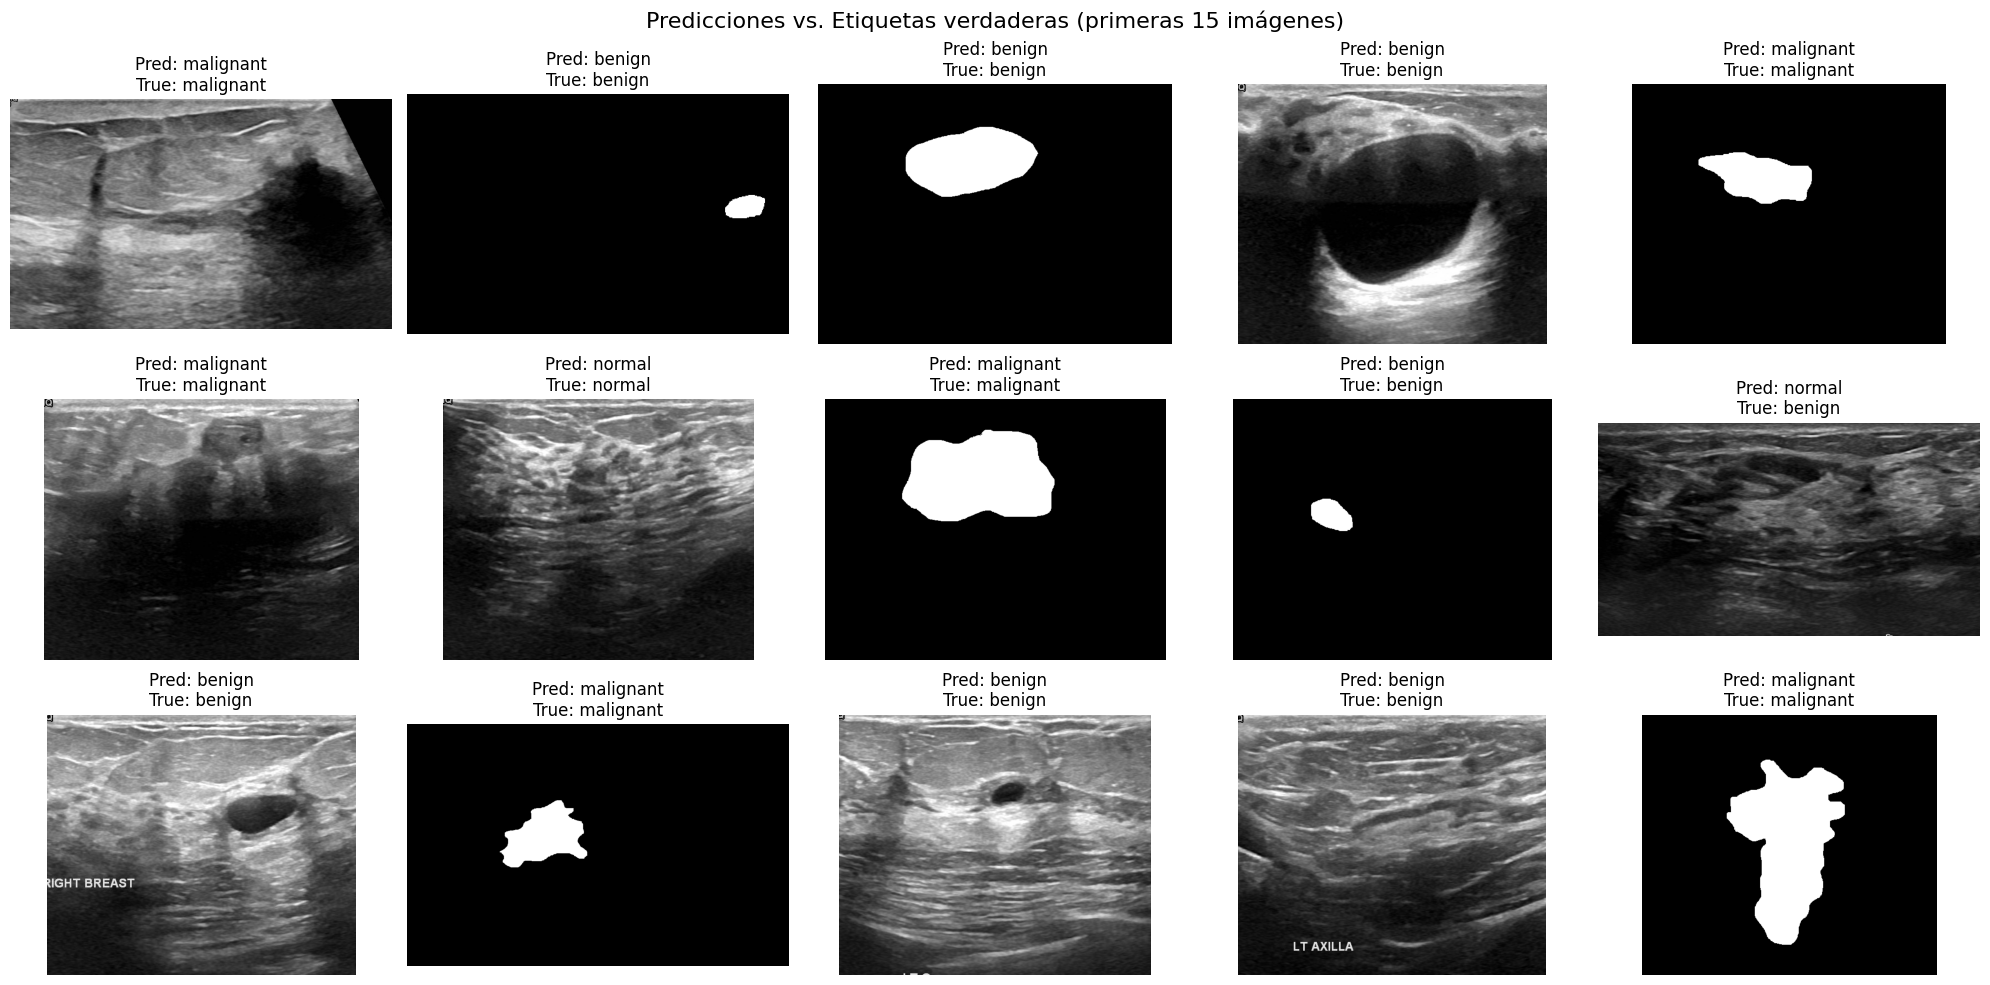

In [125]:
# [migrado] a probar

evaluate_model(
    model=model,
    dataloader=eval_dataloader,
    labels=labels,
    dataset_raw=data_test_original,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
